In [31]:
from folium.plugins import TimestampedGeoJson, HeatMap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows의 경우 맑은 고딕, Mac의 경우 AppleGothic 사용)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
from matplotlib import cm, colors
from scipy.stats import gaussian_kde

import seaborn as sns
import folium
import pandas as pd
import numpy as np
import os


### 1. Data Load

In [32]:
FOOT_TRAFFIC_DATA_PATH = './Foot-Traffic-DataSet/'

In [33]:
foottraffic_file_names = os.listdir(FOOT_TRAFFIC_DATA_PATH)
print(len(foottraffic_file_names))

116


In [34]:
dataframes = []
for dataset_name in foottraffic_file_names :
    file_path = FOOT_TRAFFIC_DATA_PATH+dataset_name
    df = pd.read_csv(file_path, encoding='euc-kr')
    dataframes.append(df)

In [35]:
foot_traffic_data = pd.concat(dataframes, ignore_index=True)

In [36]:
wifi_loc = pd.read_csv('../Public-WiFi/count_wifi_loc.csv', index_col=0)

### 2. Data Preprocessing

#### 1) FootTraffic

In [37]:
foot_traffic_data

,핫스팟 장소명,실시간 인구현황,장소 혼잡도 지표,실시간 인구 지표 최소값,실시간 인구 지표 최대값,상주 인구 비율,비상주 인구 비율,실시간 인구 데이터 업데이트 시간
0,4·19 카페거리,NaN,여유,1000,1500,31.6,68.4,2024-11-13 10:55
1,4·19 카페거리,NaN,여유,1000,1500,30.9,69.1,2024-11-13 11:00
2,4·19 카페거리,NaN,여유,1000,1500,30.6,69.4,2024-11-13 11:10
3,4·19 카페거리,NaN,여유,1000,1500,28.6,71.4,2024-11-13 11:20
4,4·19 카페거리,NaN,여유,1000,1500,28.1,71.9,2024-11-13 11:30
...,...,...,...,...,...,...,...,...
172645,회기역,NaN,여유,10000,12000,22.9,77.1,2024-11-25 12:55
172646,회기역,NaN,여유,10000,12000,25.6,74.4,2024-11-25 13:05
172647,회기역,NaN,여유,10000,12000,24.4,75.6,2024-11-25 13:15
172648,회기역,NaN,여유,10000,12000,24.1,75.9,2024-11-25 13:25


In [38]:
foot_traffic_data['실시간 인구현황'].isnull().count()

np.int64(172650)

In [39]:
foot_traffic_data.drop(columns=['실시간 인구현황'], inplace=True)

In [40]:
foot_traffic_data.columns = foot_traffic_data.columns.str.replace(' ', '')

In [41]:
foot_traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172650 entries, 0 to 172649
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   핫스팟장소명          172650 non-null  object 
 1   장소혼잡도지표         172650 non-null  object 
 2   실시간인구지표최소값      172650 non-null  int64  
 3   실시간인구지표최대값      172650 non-null  int64  
 4   상주인구비율          172650 non-null  float64
 5   비상주인구비율         172650 non-null  float64
 6   실시간인구데이터업데이트시간  172650 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 9.2+ MB


In [42]:
foot_traffic_data['실시간인구데이터업데이트시간'] = pd.to_datetime(foot_traffic_data['실시간인구데이터업데이트시간'], errors='coerce')

In [43]:
unique_place = foot_traffic_data['핫스팟장소명'].unique()

#### 2) Wifi

In [44]:
wifi_loc_unique = wifi_loc['Name'].unique()

In [45]:
place_not_in_wifi = []
for i in unique_place :
    if i not in wifi_loc_unique :
        place_not_in_wifi.append(i)

In [46]:
place_not_in_wifi

['경복궁', '동대문 관광특구']

In [47]:
wifi_loc.sort_values(by='Name', inplace=True)

In [48]:
float(wifi_loc[wifi_loc['Name']=='4·19 카페거리']['Latitude'].values[0])

37.645275

In [49]:
hotspot_loc = {wifi_name : [float(wifi_loc[wifi_loc['Name']=='4·19 카페거리']['Latitude'].values[0]), \
                            float(wifi_loc[wifi_loc['Name']==wifi_name]['Longitude'].values[0])] for wifi_name in wifi_loc_unique}

#### 3)  Merge Data

In [50]:
foot_traffic_data_loc = pd.merge(foot_traffic_data, 
                                 wifi_loc.rename(columns={'Name':'핫스팟장소명'}),
                                 on='핫스팟장소명',
                                 how='left')

In [51]:
foot_traffic_data_loc.dropna(axis=0, inplace=True)

#### 4) Day&TimeZone

In [52]:
foot_traffic_data_loc['요일'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.day_name(locale='ko_KR')
foot_traffic_data_loc['시간대'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.hour

In [53]:
average_traffic_by_day_and_hour = (
    foot_traffic_data_loc.groupby(['요일','시간대','핫스팟장소명'])['실시간인구지표최대값']
    .quantile(0.75)
    .reset_index()
)

In [54]:
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
average_traffic_by_day_and_hour['요일'] = pd.Categorical(
    average_traffic_by_day_and_hour['요일'], categories=weekday_order, ordered=True
)

In [55]:
max_traffic_by_day_and_location = (
    foot_traffic_data_loc.groupby(['요일', '핫스팟장소명'])['실시간인구지표최대값']
    .max()
    .reset_index()
)

In [56]:
max_traffic_by_day_and_location.head(3)

,요일,핫스팟장소명,실시간인구지표최대값
0,금요일,4·19 카페거리,1500
1,금요일,DDP(동대문디자인플라자),8000
2,금요일,DMC(디지털미디어시티),46000


### 3. Visualizing

In [57]:
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

#### 1) Map

##### 1)-1. 요일별 지역별 유동인구

In [58]:
foot_traffic_data_loc
실시간인구최대값(비상주인구 비율 인구수를 구하면 됨)
(실시간인구최대값*비상주인구비율+b) - (실시간인구최대값*상주인구비율)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2255784111.py, line 2)

In [ ]:
# 가중치 설정
w_resident = 1.0   # 상주 인구 가중치
w_non_resident = 1.8  # 비상주 인구 가중치

# 데이터 그룹화 및 계산 적용
max_traffic_by_day_and_location = (
    foot_traffic_data_loc.groupby(['요일', '핫스팟장소명', 'Latitude', 'Longitude'])
    .apply(lambda group: (
        group['실시간인구지표최대값'] * group['비상주인구비율'] * w_non_resident -
        group['실시간인구지표최대값'] * group['상주인구비율'] * w_resident
    ).quantile(0.75))  # 제3사분위수 계산
    .reset_index(name='가중치적용_유동인구')
)

KeyboardInterrupt: 

In [ ]:
# 지도 생성
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 요일별 레이어 추가
days_of_week = max_traffic_by_day_and_location['요일'].unique()
for day in days_of_week:
    # 요일별 데이터 필터링
    day_data = max_traffic_by_day_and_location[max_traffic_by_day_and_location['요일'] == day]
    
    # HeatMap 데이터 준비
    heatmap_data = day_data[['Latitude', 'Longitude', '가중치적용_유동인구']].dropna().values.tolist()
    
    # FeatureGroup 생성
    feature_group = folium.FeatureGroup(name=day, show=(day == "월요일"))  # 월요일 레이어 기본 활성화
    
    # HeatMap 추가
    HeatMap(
        data=heatmap_data,
        radius=20,  # 히트맵 반경 확대
        blur=15,
        max_zoom=1
    ).add_to(feature_group)
    
    # 클릭 가능한 투명 마커 추가
    for _, row in day_data.iterrows():
        popup_html = f"""
            <div style="background-color: rgba(255, 255, 255, 0.8); padding: 5px; border-radius: 5px;">
                <strong>{row['핫스팟장소명']}</strong><br>
                최대 유동인구: {row['가중치적용_유동인구']:,}
            </div>
        """
        popup = folium.Popup(popup_html, max_width=150)
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=10,  # 작게 표시해 눈에 띄지 않도록 설정
            color="rgba(0,0,0,0)",  # 테두리 투명
            fill=True,
            fill_color="rgba(0,0,0,0)",  # 내부 투명
            fill_opacity=0.0  # 완전 투명
        ).add_to(feature_group).add_child(popup)
    
    # 지도에 FeatureGroup 추가
    feature_group.add_to(seoul_map)

# LayerControl 추가
folium.LayerControl().add_to(seoul_map)

# 지도 저장
output_file = "seoul_heatmap_with_multiple_popups.html"
seoul_map.save(output_file)

# JavaScript 수정: 팝업이 닫히지 않도록 설정
with open(output_file, "r", encoding="utf-8") as file:
    map_html = file.read()

# 유동인구 최대값 및 최소값 자동 팝업 열기
# 상위 3개의 지역 팝업 열기
map_html = map_html.replace(
    "</script>",
    """
    document.addEventListener("DOMContentLoaded", function() {
        const mapObject = Object.values(window).find(obj => obj instanceof L.Map);
        if (mapObject) {
            const setPopupOptions = () => {
                mapObject.eachLayer(function (layer) {
                    if (layer instanceof L.CircleMarker && layer.getPopup()) {
                        layer.getPopup().options.autoClose = false;
                        layer.getPopup().options.closeOnClick = false;
                    }
                });
            };

            const openTopPopups = () => {
                const layersWithValues = [];
                
                mapObject.eachLayer(function (layer) {
                    if (layer instanceof L.CircleMarker && layer.getPopup()) {
                        let popupContent = layer.getPopup().getContent();

                        if (typeof popupContent !== "string") {
                            popupContent = popupContent.outerHTML || "";
                        }

                        const match = popupContent.match(/최대 유동인구: ([\\d,]+)/);
                        if (match) {
                            const value = parseInt(match[1].replace(/,/g, ''));
                            layersWithValues.push({ layer, value });
                        }
                    }
                });

                layersWithValues
                    .sort((a, b) => b.value - a.value)
                    .slice(0, 3)
                    .forEach(item => item.layer.openPopup());
            };

            setPopupOptions();
            openTopPopups();

            mapObject.on("overlayadd", function () {
                setPopupOptions();
                openTopPopups();
            });
        }
    });
    </script>
    """
)

# 수정된 HTML 저장
with open(output_file, "w", encoding="utf-8") as file:
    file.write(map_html)

print(f"지도 파일이 '{output_file}'로 저장되었습니다.")

지도 파일이 'seoul_heatmap_with_multiple_popups.html'로 저장되었습니다.


##### 1)-2. 지역별 유동인구

In [ ]:
quartile_75_traffic = max_traffic_by_day_and_location.groupby(['핫스팟장소명', 'Latitude', 'Longitude'])[["실시간인구지표최대값"]].quantile(0.75).reset_index()

In [ ]:
quartile_75_traffic

,핫스팟장소명,Latitude,Longitude,실시간인구지표최대값
0,4·19 카페거리,37.645275,127.007675,1500.0
1,DDP(동대문디자인플라자),37.566990,127.010290,5000.0
2,DMC(디지털미디어시티),37.579277,126.891790,44000.0
3,가락시장,37.493470,127.111890,8000.0
4,가로수길,37.521390,127.023575,28000.0
...,...,...,...,...
109,해방촌·경리단길,37.542370,126.987180,5750.0
110,혜화역,37.582480,127.001760,15000.0
111,홍대 관광특구,37.553917,126.921270,67000.0
112,홍대입구역(2호선),37.556763,126.923004,22000.0


In [ ]:
# 지도 생성
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# HeatMap 데이터 준비
heatmap_data = quartile_75_traffic[['Latitude', 'Longitude', '실시간인구지표최대값']].dropna().values.tolist()

# HeatMap 추가
HeatMap(
    data=heatmap_data,
    radius=20,  # 반경 설정
    blur=15,    # 흐림 효과
    max_zoom=1
).add_to(seoul_map)

# 클릭 가능한 투명 마커 추가
for _, row in quartile_75_traffic.iterrows():
    popup_html = f"""
        <div style="background-color: rgba(255, 255, 255, 0.8); padding: 5px; border-radius: 5px;">
            <strong>{row['핫스팟장소명']}</strong><br>
            최대 유동인구: {row['실시간인구지표최대값']:,}
        </div>
    """
    popup = folium.Popup(popup_html, max_width=150)
    
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=10,
        color="rgba(0,0,0,0)",  # 테두리 투명
        fill=True,
        fill_color="rgba(0,0,0,0)",  # 내부 투명
        fill_opacity=0.0  # 완전 투명
    ).add_to(seoul_map).add_child(popup)

# 지도 저장
output_file = "seoul_quartile_75_heatmap_with_popups.html"
seoul_map.save(output_file)

# JavaScript 수정: 상위 3개 팝업 열기 추가
with open(output_file, "r", encoding="utf-8") as file:
    map_html = file.read()

map_html = map_html.replace(
    "</script>",
    """
    document.addEventListener("DOMContentLoaded", function() {
    const mapObject = Object.values(window).find(obj => obj instanceof L.Map);

    if (mapObject) {
        // 팝업 옵션 설정
        const setPopupOptions = () => {
            mapObject.eachLayer(function (layer) {
                if (layer instanceof L.CircleMarker && layer.getPopup()) {
                    // Popup 옵션 설정
                    const popup = layer.getPopup();
                    popup.options.autoClose = false;  // 다른 팝업 클릭 시 닫히지 않음
                    popup.options.closeOnClick = false; // 마커 클릭 시 팝업 닫히지 않음

                    // Popup 재바인딩 (필수)
                    layer.bindPopup(popup);
                }
            });
        };

        // 상위 3개 팝업 열기
        const openTopPopups = () => {
            const layersWithValues = [];

            mapObject.eachLayer(function (layer) {
                if (layer instanceof L.CircleMarker && layer.getPopup()) {
                    let popupContent = layer.getPopup().getContent();

                    if (typeof popupContent !== "string") {
                        popupContent = popupContent.outerHTML || "";
                    }

                    const match = popupContent.match(/최대 유동인구: ([\d,]+)/);
                    if (match) {
                        const value = parseInt(match[1].replace(/,/g, ''));
                        layersWithValues.push({ layer, value });
                    }
                }
            });

            layersWithValues
                .sort((a, b) => b.value - a.value)
                .slice(0, 3)
                .forEach(item => item.layer.openPopup());
        };

        // 초기 설정 실행
        setPopupOptions();
        openTopPopups();
    }
});
    </script>
    """
)

# 수정된 HTML 저장
with open(output_file, "w", encoding="utf-8") as file:
    file.write(map_html)

print(f"지도 파일이 '{output_file}'로 저장되었습니다.")

<>:44: SyntaxWarning: invalid escape sequence '\d'
<>:44: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jungb\AppData\Local\Temp\ipykernel_59764\1687706648.py:44: SyntaxWarning: invalid escape sequence '\d'
  """


지도 파일이 'seoul_quartile_75_heatmap_with_popups.html'로 저장되었습니다.


#### 2) Graph

In [ ]:
max_traffic_by_day_and_location_pivot = max_traffic_by_day_and_location.pivot_table(
    index='핫스팟장소명', columns='요일', values='가중치적용_유동인구'
)

In [ ]:
max_traffic_by_day_and_location_pivot.columns = pd.Categorical(
    max_traffic_by_day_and_location_pivot.columns,
    categories=weekday_order,
    ordered=True
)

In [ ]:
max_traffic_by_day_and_location_pivot = max_traffic_by_day_and_location_pivot.reindex(columns=weekday_order)

##### 2)-1. 전체 그래프

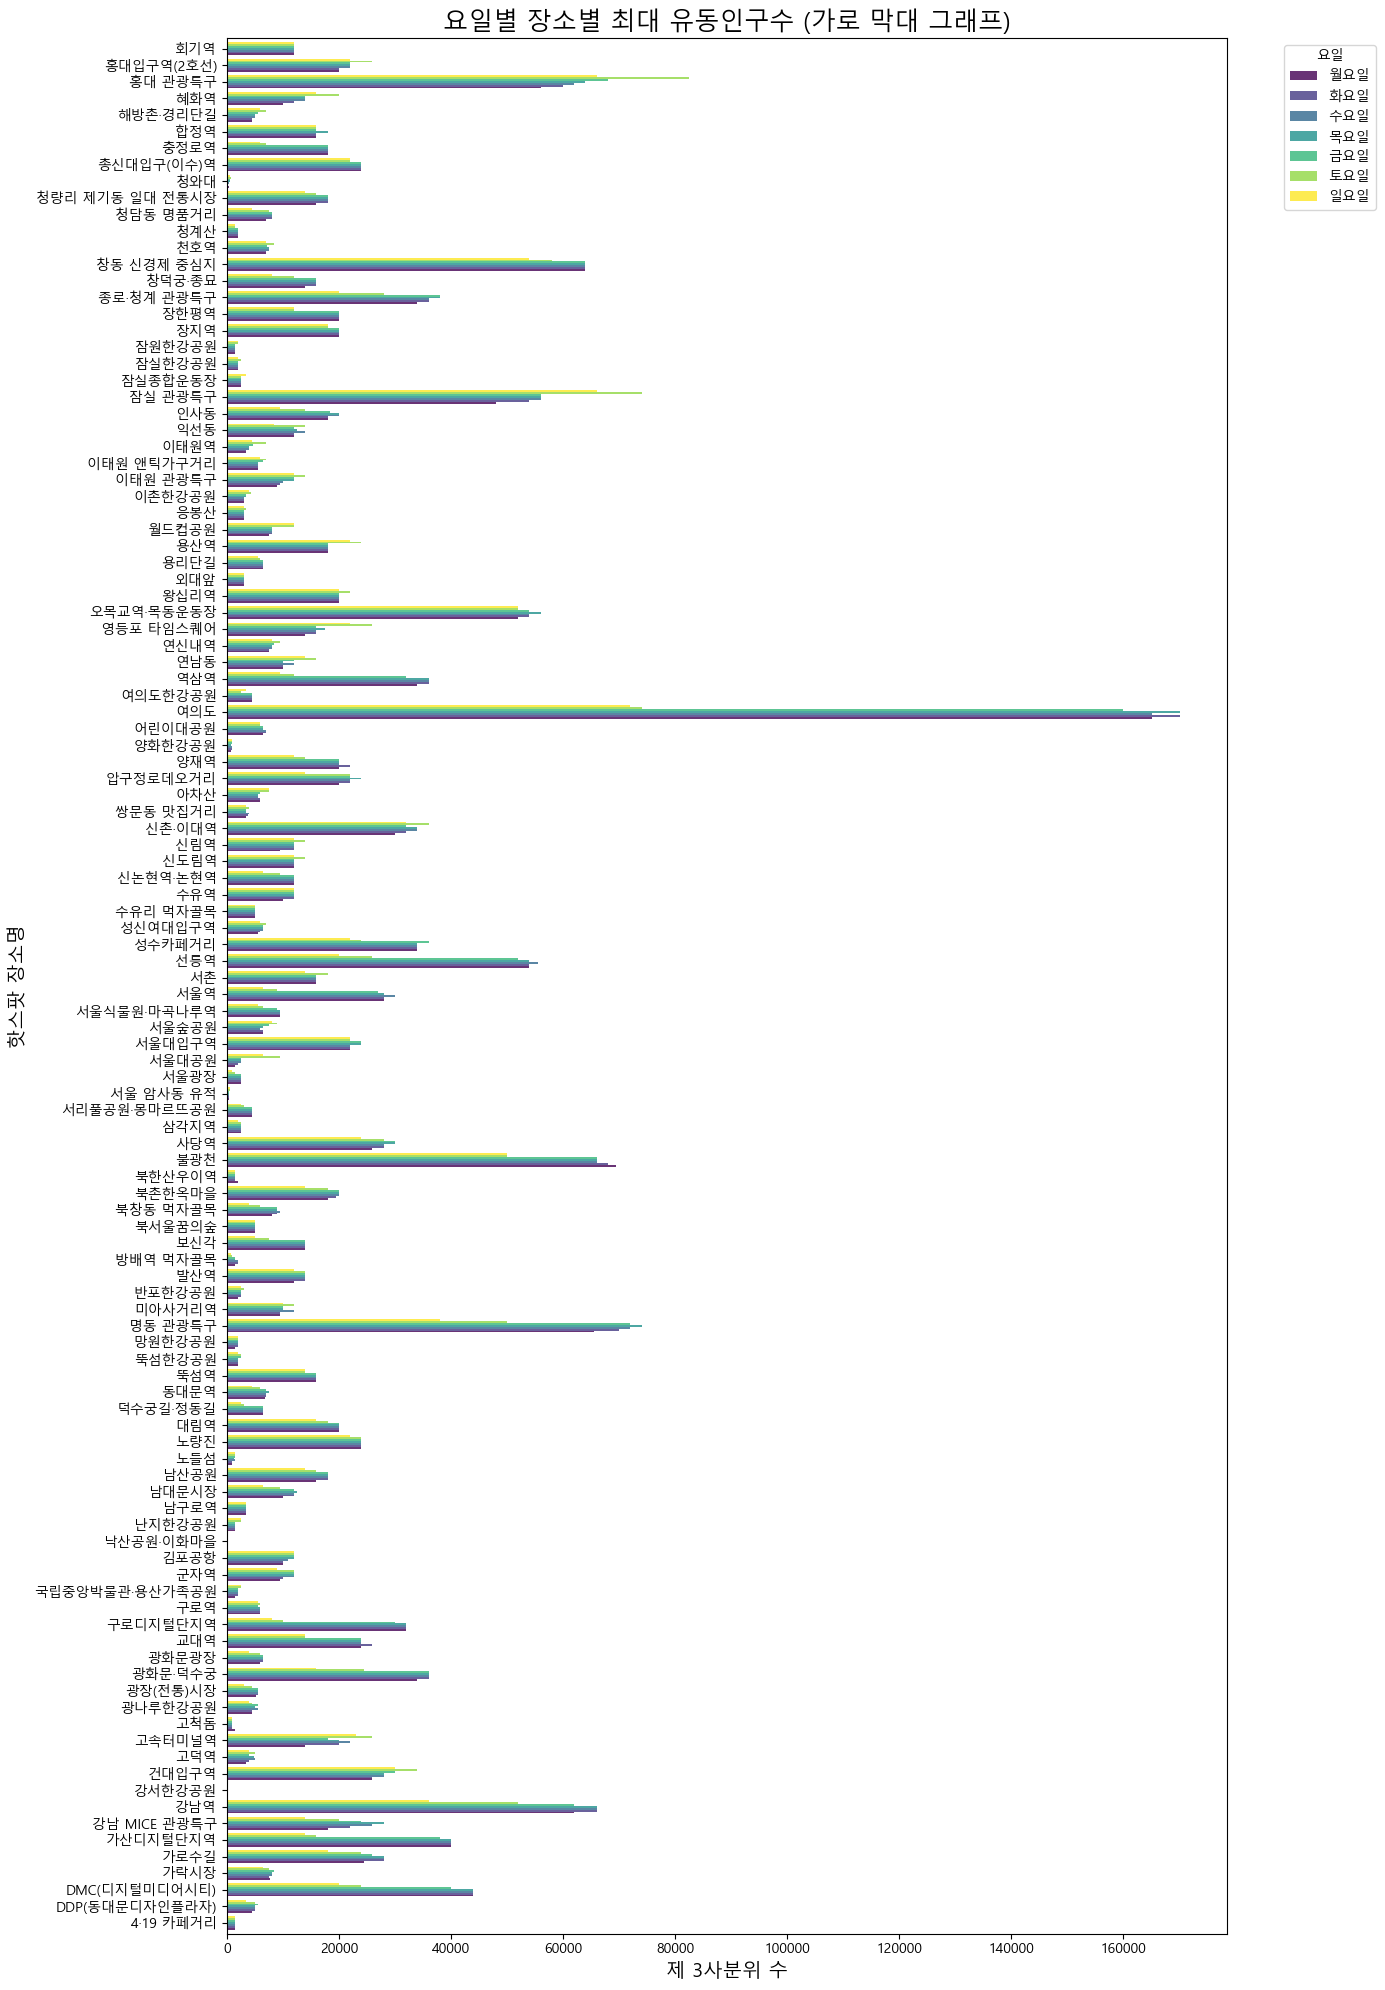

In [ ]:
# 바 그래프 시각화
ax = max_traffic_by_day_and_location_pivot.plot(
    kind='barh',
    figsize=(14, 20),
    stacked=False,
    colormap='viridis',
    alpha=0.8,
    width=0.8
)

# 그래프 제목 및 축 레이블
plt.title('요일별 장소별 최대 유동인구수 (가로 막대 그래프)', fontsize=18)
plt.xlabel('제 3사분위 수', fontsize=14)
plt.ylabel('핫스팟 장소명', fontsize=14)

# 범례 위치 조정
plt.legend(title='요일', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()


##### 2)-2. 요일별 지역별 그래프

In [ ]:
top_3_per_day = max_traffic_by_day_and_location_pivot.apply(
    lambda col: col.nlargest(3), axis=0  # 각 요일(컬럼)에서 상위 3개 추출
)

In [ ]:
top_3_per_day.T

핫스팟장소명,강남역,명동 관광특구,여의도,잠실 관광특구,홍대 관광특구
월요일,NaN,6920040.0,NaN,6140820.0,6079200.0
화요일,6454560.0,7445920.0,NaN,6375600.0,NaN
수요일,7579960.0,8644800.0,NaN,NaN,7561620.0
목요일,7384800.0,8125920.0,NaN,NaN,7537120.0
금요일,NaN,8290320.0,NaN,7567800.0,8161920.0
토요일,8013000.0,NaN,NaN,11988740.0,12725600.0
일요일,NaN,NaN,6216480.0,10369260.0,9828720.0


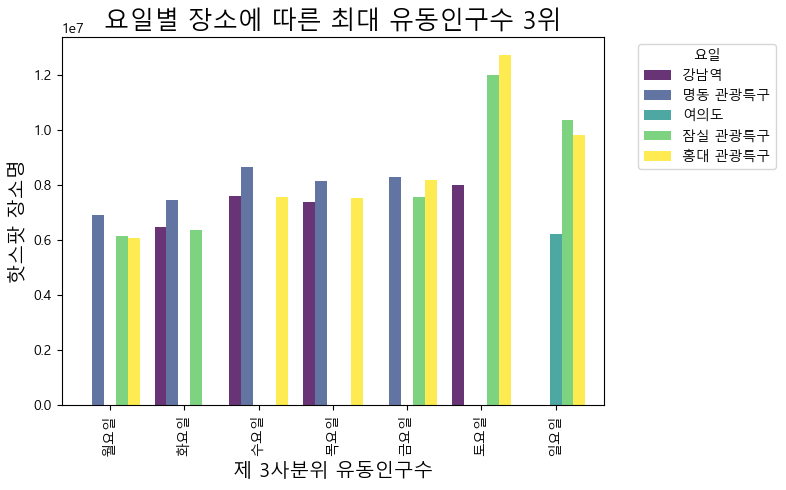

In [ ]:
ax = top_3_per_day.T.plot(
    kind='bar',
    figsize=(8, 5),
    stacked=False,
    colormap='viridis',
    alpha=0.8,
    width=0.8
)

# 그래프 제목 및 축 레이블
plt.title('요일별 장소에 따른 최대 유동인구수 3위', fontsize=18)
plt.xlabel('제 3사분위 유동인구수', fontsize=14)
plt.ylabel('핫스팟 장소명', fontsize=14)

# 범례 위치 조정
plt.legend(title='요일', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()